USD: Loaded 748396 records.
EUR: Loaded 748396 records.
GBP: Loaded 748396 records.
JPY: Loaded 748396 records.
CNY: Loaded 748396 records.
Volatility for USD:
to
AED    0.0
AFN    0.0
ALL    0.0
Name: change, dtype: float64

Volatility for EUR:
to
AED    0.0
AFN    0.0
ALL    0.0
Name: change, dtype: float64

Volatility for GBP:
to
AED    0.0
AFN    0.0
ALL    0.0
Name: change, dtype: float64

Volatility for JPY:
to
AED    0.0
AFN    0.0
ALL    0.0
Name: change, dtype: float64

Volatility for CNY:
to
AED    0.0
AFN    0.0
ALL    0.0
Name: change, dtype: float64



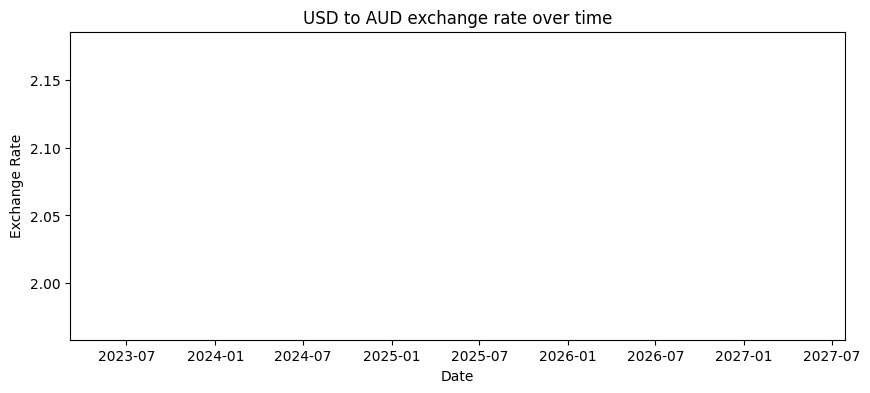

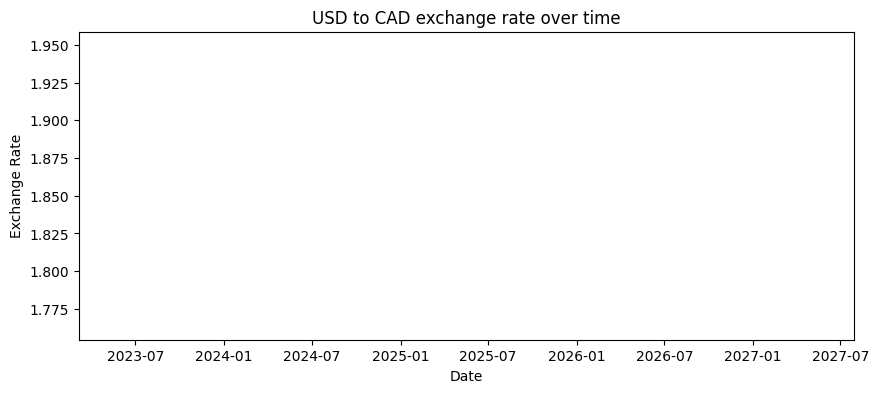

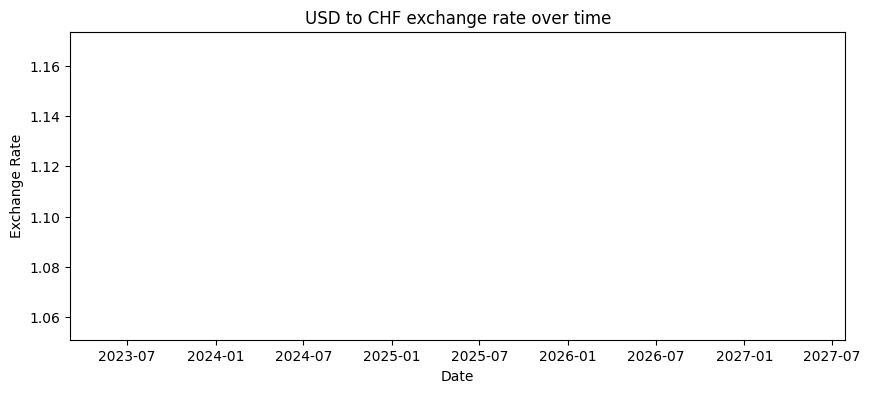

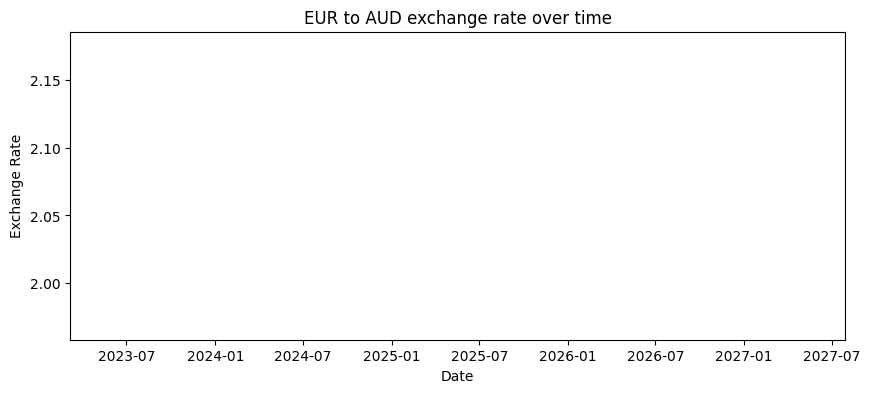

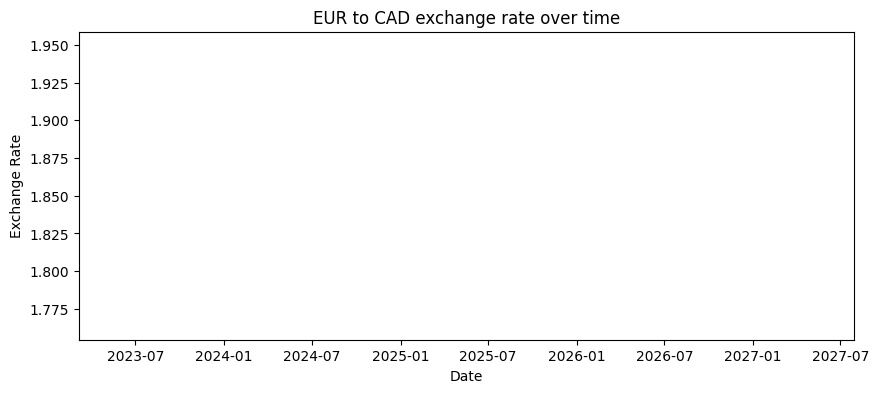

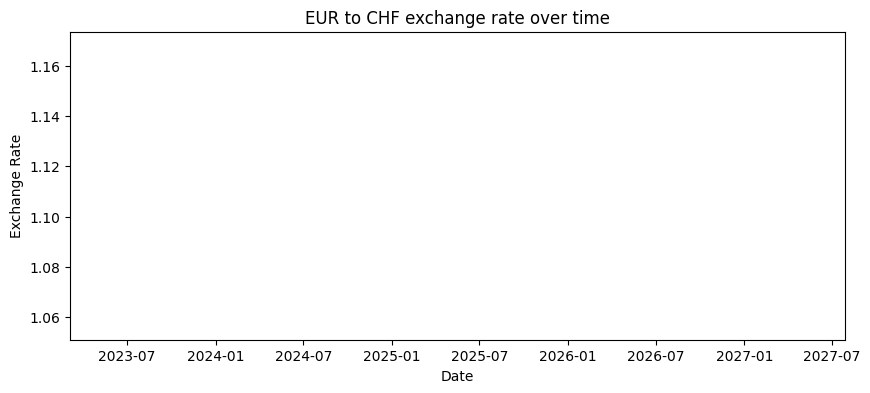

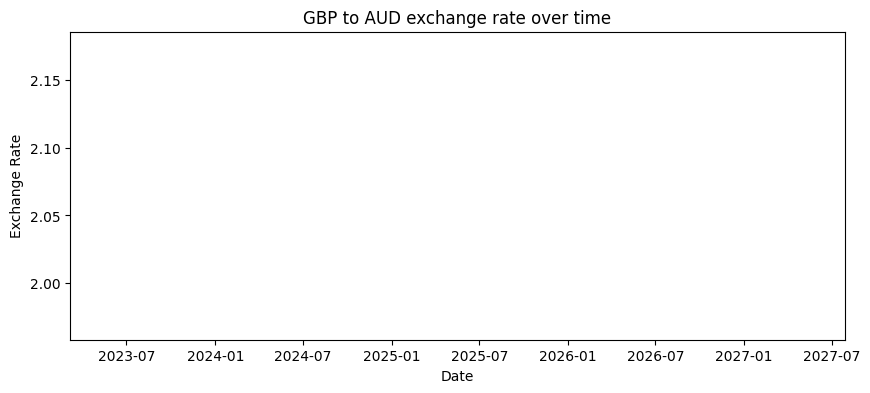

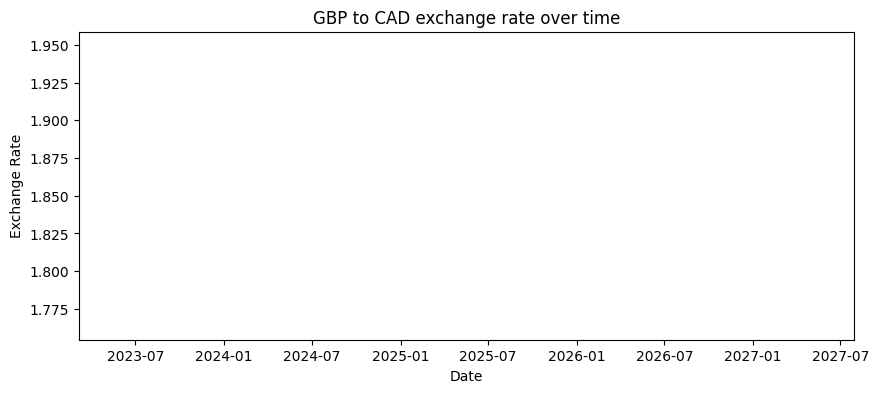

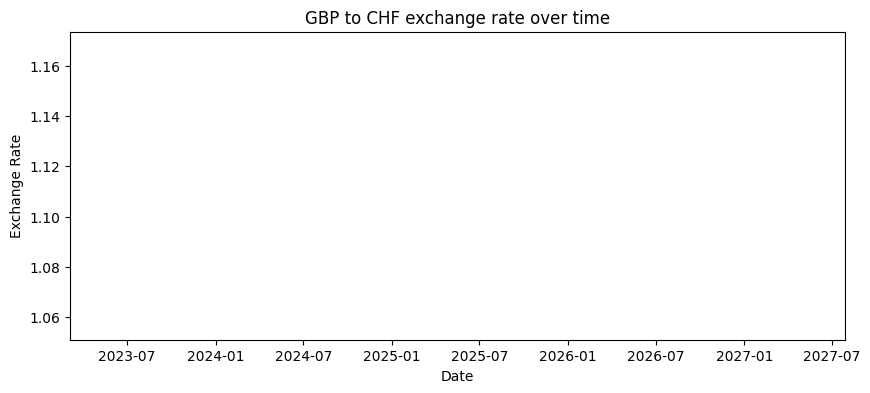

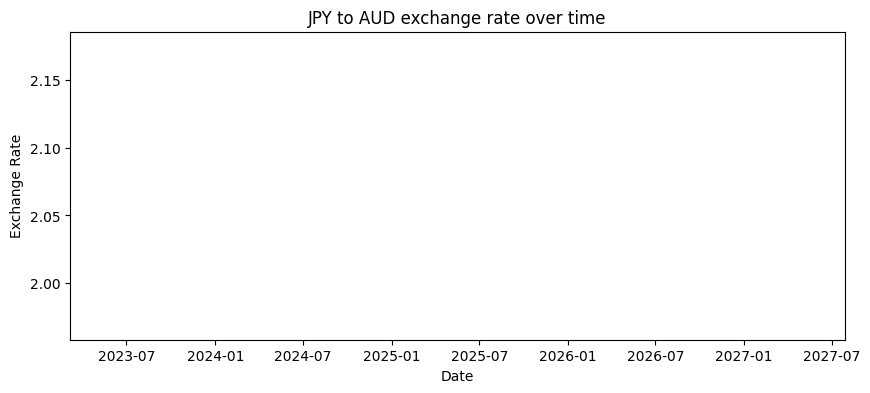

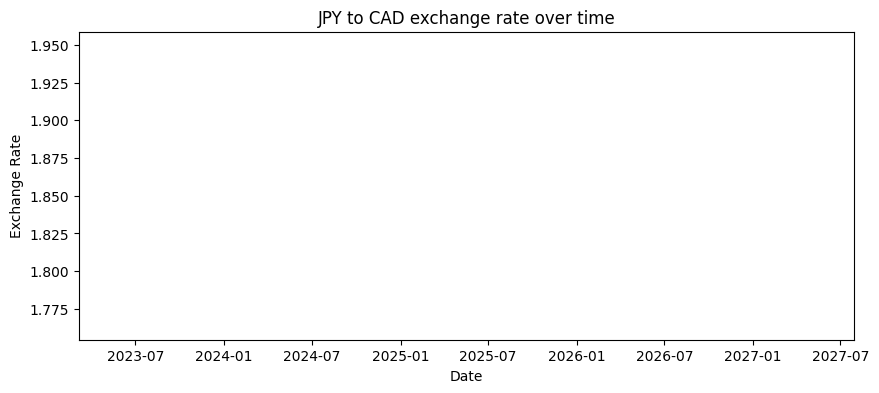

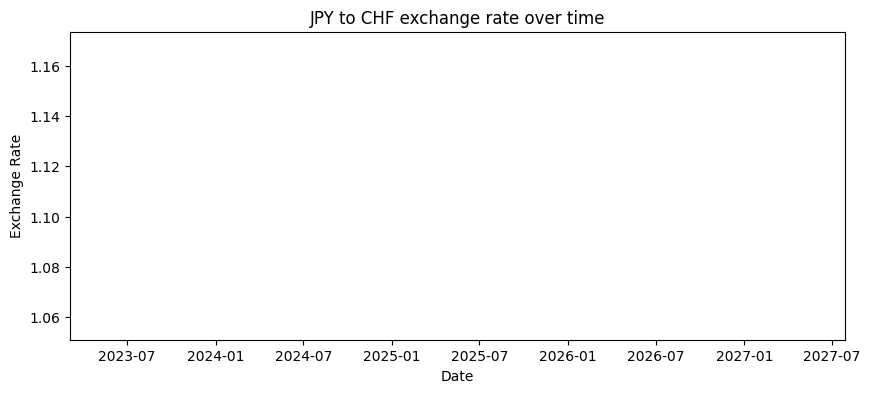

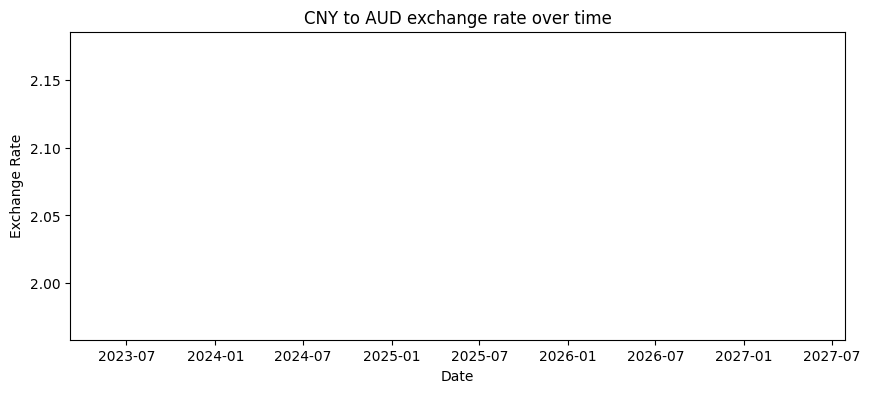

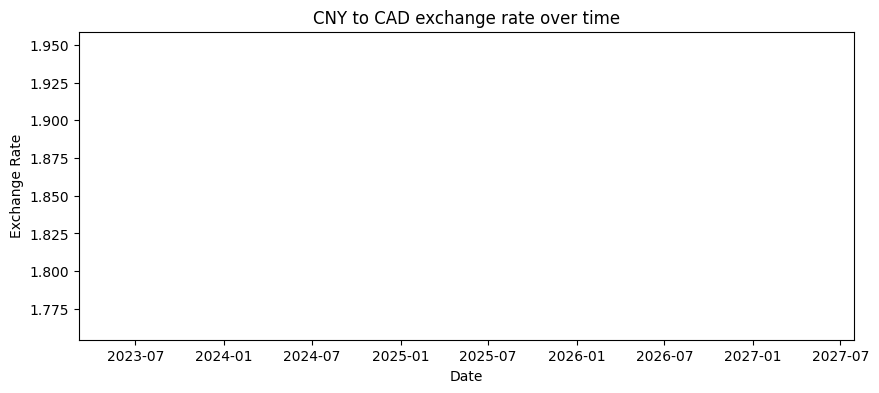

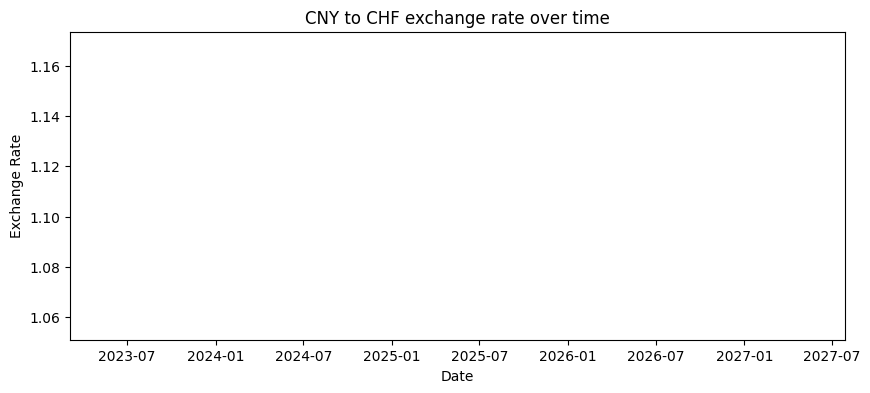

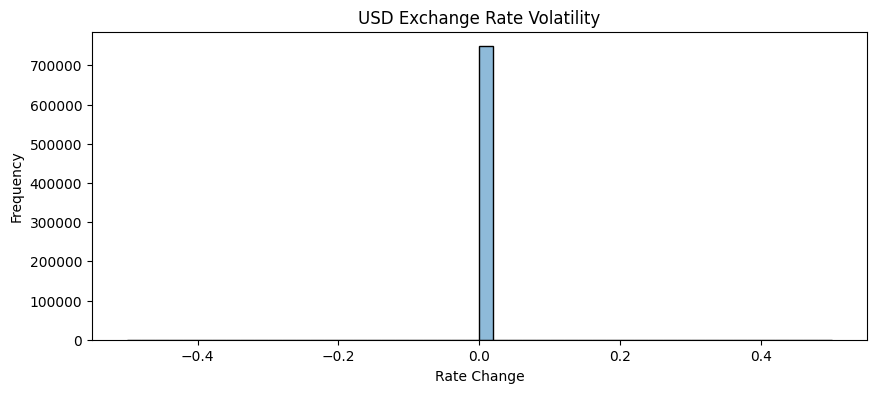

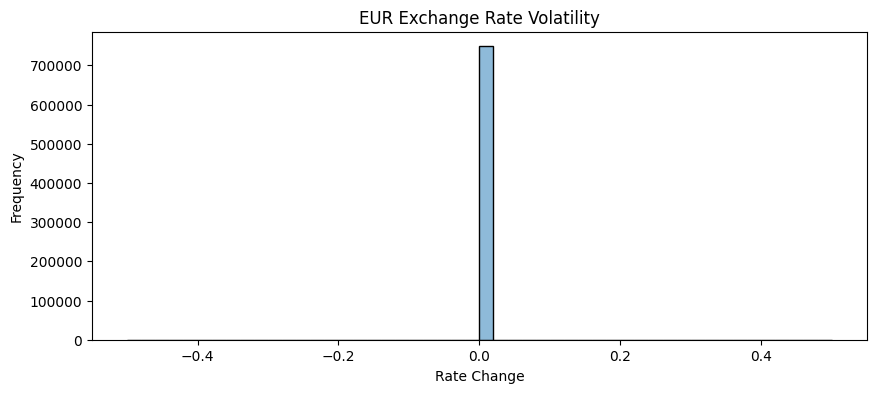

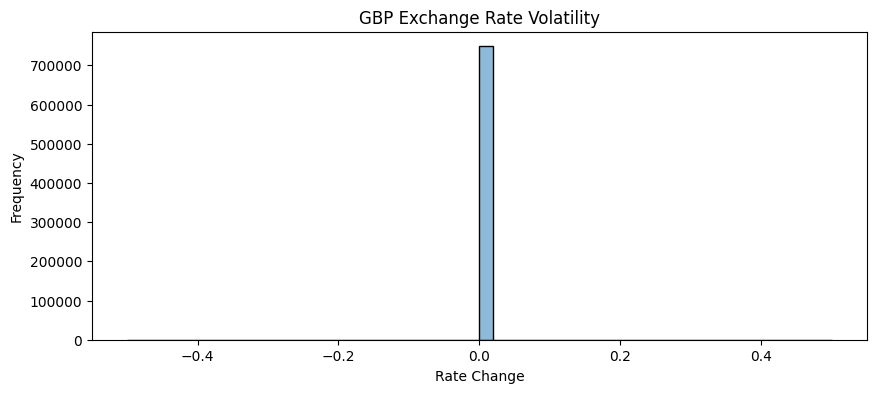

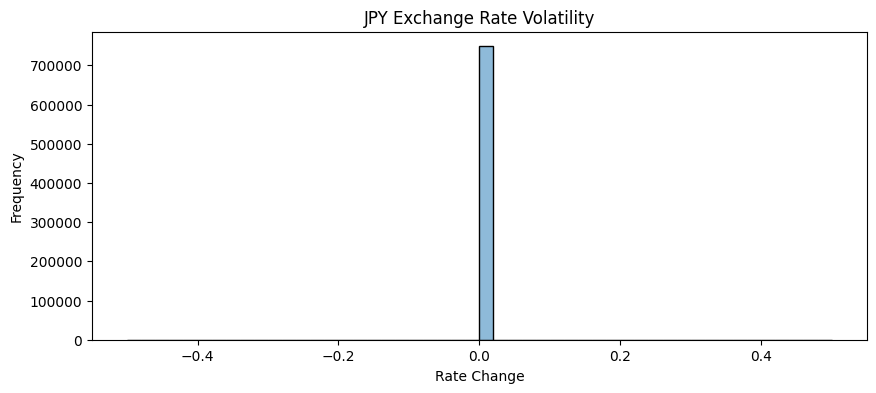

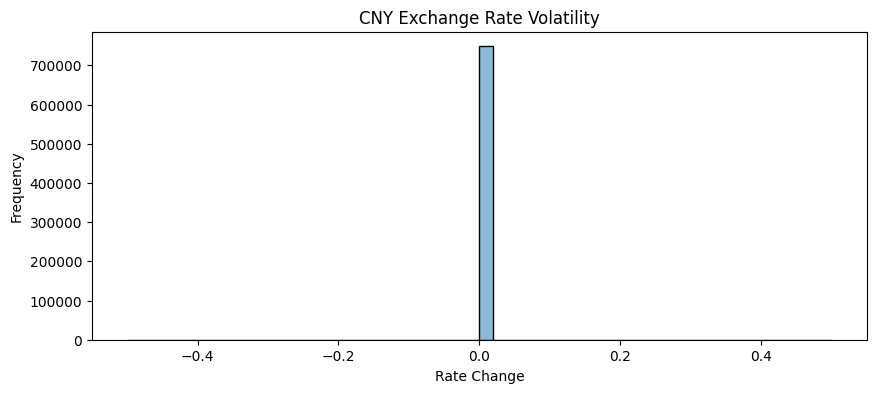

c:\Users\esska\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:202: RuntimeWarning: All-NaN slice encountered
  vmin = np.nanmin(calc_data)
c:\Users\esska\AppData\Local\Programs\Python\Python313\Lib\site-packages\seaborn\matrix.py:207: RuntimeWarning: All-NaN slice encountered
  vmax = np.nanmax(calc_data)


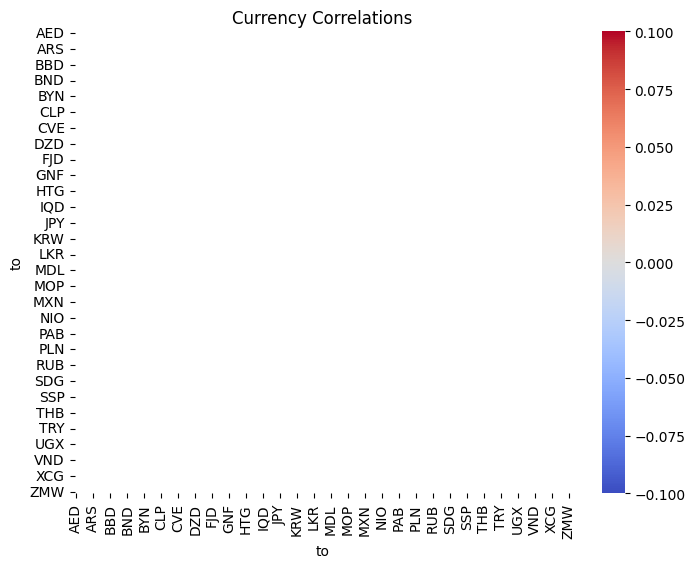

In [10]:
# Quest 2: The Seer of Exchange
# Unveiling hidden trends in currency exchange rates

# Import necessary libraries
%matplotlib inline
import os
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Define the list of currencies to analyze
currencies = ["USD", "EUR", "GBP", "JPY", "CNY"]

# Function to load data for a specific currency
def load_data(currency):
    folder = f"data"
    all_data = []

    if not os.path.exists(folder):
        print(f"Folder missing for {currency}, skipping.")
        return pd.DataFrame()

    for file in sorted(os.listdir(folder)):
        if file.endswith(".json"):
            with open(os.path.join(folder, file), "r") as f:
                try:
                    data = json.load(f)
                    # Check if expected keys exist
                    if "exchange_rates" in data and "@date" in data["exchange_rates"]:
                        date = data["exchange_rates"]["@date"]
                        rate_info = data["exchange_rates"].get("exchange_rate", [])

                        if isinstance(rate_info, dict):  # Handle single entry format
                            rate_info = [rate_info]

                        for rate in rate_info:
                            if "@to_currency" in rate and "rate" in rate:
                                to_code = rate["@to_currency"]
                                value = float(rate["rate"])
                                all_data.append({"date": date, "to": to_code, "rate": value})
                except json.JSONDecodeError:
                    print(f"Error reading {file}, skipping.")
                    continue

    df = pd.DataFrame(all_data)

    # Ensure 'date' is properly formatted
    if "date" in df.columns:
        df["date"] = pd.to_datetime(df["date"], errors="coerce")

    return df.dropna()

# Load data for all selected currencies
all_frames = {currency: load_data(currency) for currency in currencies}

# Print dataset summary
for currency, df in all_frames.items():
    if df.empty:
        print(f"No data found for {currency}.")
    else:
        print(f"{currency}: Loaded {df.shape[0]} records.")

# Function to plot exchange rate trends over time
def plot_trends(data_frames):
    for currency, df in data_frames.items():
        if df.empty:
            continue

        top_currencies = df["to"].value_counts().head(3).index

        for to_curr in top_currencies:
            sub = df[df["to"] == to_curr]

            plt.figure(figsize=(10, 4))
            sns.lineplot(data=sub, x="date", y="rate")
            plt.title(f"{currency} to {to_curr} exchange rate over time")
            plt.xlabel("Date")
            plt.ylabel("Exchange Rate")
            plt.show()

# Function to analyze volatility in exchange rates
def analyze_volatility(data_frames):
    for currency, df in data_frames.items():
        if df.empty:
            continue

        df = df.sort_values("date")
        df["change"] = df.groupby("to")["rate"].diff().abs()

        mean_volatility = df.groupby("to")["change"].mean().sort_values(ascending=False)
        print(f"Volatility for {currency}:")
        print(mean_volatility.head(3))
        print()

# Function to visualize volatility distribution
def plot_volatility(data_frames):
    for currency, df in data_frames.items():
        if df.empty:
            continue

        df["change"] = df.groupby("to")["rate"].diff().abs()

        plt.figure(figsize=(10, 4))
        sns.histplot(df["change"].dropna(), bins=50, kde=True)
        plt.title(f"{currency} Exchange Rate Volatility")
        plt.xlabel("Rate Change")
        plt.ylabel("Frequency")
        plt.show()

# Function to plot currency correlations
def plot_correlation(data_frames):
    # Filter out empty DataFrames
    valid_frames = [df for df in data_frames.values() if not df.empty]

    if not valid_frames:
        print("Error: No valid data available for correlation analysis.")
        return

    combined_df = pd.concat(valid_frames, ignore_index=True)

    # Ensure 'date' exists and is formatted correctly
    if "date" not in combined_df.columns:
        print("Error: 'date' column missing in combined dataset.")
        return

    combined_df["date"] = pd.to_datetime(combined_df["date"], errors="coerce")
    combined_df = combined_df.dropna(subset=["date"])  # Remove invalid dates

    # **Fix: Aggregate duplicate date-to_currency entries**
    combined_df = combined_df.groupby(["date", "to"], as_index=False).agg({"rate": "mean"})

    # Pivot data for correlation analysis
    pivot_df = combined_df.pivot(index="date", columns="to", values="rate")

    if pivot_df.empty:
        print("Error: No data available for correlation analysis after pivoting.")
        return

    plt.figure(figsize=(8, 6))
    sns.heatmap(pivot_df.corr(), annot=True, cmap="coolwarm")
    plt.title("Currency Correlations")
    plt.show()

# Run analysis and visualization
analyze_volatility(all_frames)
plot_trends(all_frames)
plot_volatility(all_frames)
plot_correlation(all_frames)